<div align="center">
    <img alt="Institut Polytechnique de Paris Logo" width="auto" height="150px" src="https://www.ip-paris.fr/sites/default/files/presse/Charte%20Graphique/Logo%20IP%20Paris%206%20%C3%A9coles%20vertical%20png.png" />
</div>

<div style="text-align: center; font-family: Arial, sans-serif; margin: 20px 0;">
    <h1 style="font-size: 32px; margin-bottom: 10px;">Language Models & Retrieval Augmented Generation Lab</h1>
    <p style="font-size: 16px; margin: 0;">Authors: 
        <strong>Tim Luka Horstmann</strong> & <strong>William Liaw</strong>
    </p>
</div>

_Note: We executed this lab on the Polytechnique lab machines. As these machines use a different hardware than Google Colab, for example, some results may be subject to hardware or normal floating point calculation variability. Yet, we expect our results to overall match the output of different hardware and differences should be neglectable in practice._

# Lab 3: Fewshot ICL

As knowledge graph requires background in SPARQL and/or LLM finetuning, this lab won't be totally related to what you saw in today's course.

We'll be delving into In Context Learning (ICL), in particular ICL fewshot, and trying to understand how it works and when to use it. To do this, we'll be using the Transformer Library, a Mistral LLM and an emotion classification dataset.


The laboratory is divided into 4 sections:
0. Setup: This section is dedicated to installing modules, loading models and loading data.You don't need to code, just run it.
1. Zeroshot Classification: Some of you may have had trouble finding a prompt that always returned a “well-formed” answer in the last lab. In this section, we'll use a “well-formed” prompt to perform zeroshot classification.
2. Fewshot Classification - Random Retrieval: One of the most common methods of improving ICL classification is to add demonstrations to the prompt. This helps the LLM to “properly format” the response and can also give semantic information about how to solve the task. In this section, we will use random retrieved demonstration and compare the results with those of section 1.
3. Fewshot Classification - Vector-based Retrieval: Extracting random demonstrations in fewshot classification can introduce bias. In addition, most semantically relevant demonstrations are not taken into account. As with did with RAG, we will use a vector representation of the example to retrieve the most relevant demonstrations.
4. Constrained Decoding: Finally, we'll discovering the `outlines` library, which contains modules that are useful to do constrained decoding.

At the end of each section (except section 0.), there's a question to answer.

## 0. Setup

In [1]:
# !pip install transformers bitsandbytes accelerate datasets outlines scikit-learn

In [2]:
import random
import re

import outlines
import torch
from datasets import load_dataset
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm
from transformers import (AutoModelForCausalLM, AutoTokenizer,
                          BitsAndBytesConfig, GenerationConfig)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
def read_hf_token(file_path):
    """Reads the Hugging Face token from a file."""
    try:
        with open(file_path, "r") as file:
            token = file.read().strip()
            if not token:
                raise ValueError("The token file is empty.")
            return token
    except FileNotFoundError:
        raise FileNotFoundError(f"Token file not found at: {file_path}")
    except Exception as e:
        raise RuntimeError(f"An error occurred while reading the token: {e}")

In [4]:
# Put your hugging face token here: https://huggingface.co/docs/hub/en/security-tokens
# You need to fill the access form with your huggingface account on this link: https://huggingface.co/mistralai/Ministral-8B-Instruct-2410
# File path to the token
hf_token_file = "token.txt"

# Read the token from the file
hf_token = read_hf_token(hf_token_file)
llm_name = "mistralai/Ministral-8B-Instruct-2410"

# We want to use 4bit quantization to save memory
quantization_config = BitsAndBytesConfig(load_in_8bit=False, load_in_4bit=True)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    llm_name, padding_side="left", token=hf_token, cache_dir="/Data/llm"
)
# Prevent some transformers specific issues.
tokenizer.use_default_system_prompt = False
tokenizer.pad_token_id = tokenizer.eos_token_id

# Load LLM.
llm = AutoModelForCausalLM.from_pretrained(
    llm_name,
    quantization_config=quantization_config,
    device_map={"": 0},  # load all the model layers on GPU 0
    torch_dtype=torch.bfloat16,  # float precision
    token=hf_token,
    cache_dir="/Data/llm",
)
# Set LLM on eval mode.
llm.eval()

tokenizer_config.json:   0%|          | 0.00/181k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.07G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(131072, 4096)
    (layers): ModuleList(
      (0-35): 36 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=12288, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=12288, bias=False)
          (down_proj): Linear4bit(in_features=12288, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSN

In [5]:
# Set up our generation configuration.
# We set max_new_token to 128 to reduce computation time (we may also lose some accuracy).
# We disable beamsearch to ensure reproducibility (we may lose some accuracy).
generation_config = GenerationConfig(
    max_new_tokens=128,
    do_sample=False,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
)

In [6]:
random.seed(42)

id2label = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}

# Dataset: https://huggingface.co/datasets/dair-ai/emotion
ds = load_dataset("dair-ai/emotion", "split")
examples = [
    {"text": ex["text"], "label": id2label[ex["label"]]} for ex in ds["test"].to_list()
]
random.shuffle(examples)

# Split examples and keep only a few samples to have short computation time.
test, train = examples[:100], examples[100:500]
print(f"Train len {len(train)}. Test len {len(test)}")
print(f"First example of test:\n{test[0]}")

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Train len 400. Test len 100
First example of test:
{'text': 'i feel a strange gratitude for the hated israeli occupation of sinai that lasted from to for actually recognizing the importance of sinais history', 'label': 'surprise'}


## 1. Zero-shot Classification

It's very similar to what you've done last time, so we're providing you with most of the code. The only thing you need to code yourself is the parse_answer function.
- We adapted the recommended classification prompt from: https://docs.mistral.ai/guides/prompting_capabilities/
- The purpose of this function is to return the first occurrence of a correct label (sadness, joy, love, anger, fear, surprise)
- We want to return "" if no answer is found.
- You can use regex or string functions.

There is a cell below to test your code. The output should be:

```
##### Example 0 #####
# You're an expert in sentiment analysis. Your task is to classify the sentence emotion after <<<>>> with one of the following predefined labels:

sadness
joy
love
anger
fear
surprise

You will only respond with the category. Do not include the word "Category". Do not provide explanations or notes.

<<<
Sentence: i feel a strange gratitude for the hated israeli occupation of sinai that lasted from to for actually recognizing the importance of sinais history
Label:
>>>
# sadness
# sadness
```

In [7]:
zeroshot_prompt = """
You're an expert in sentiment analysis. Your task is to classify the sentence emotion after <<<>>> with one of the following predefined labels:

sadness
joy
love
anger
fear
surprise

You will only respond with the label. Do not include the word "Label". Do not provide explanations or notes.

<<<
Sentence: {sentence}
Label:
>>>
""".strip()


def generate(prompt, llm=llm, generation_config=generation_config):
    # Create turns with the given prompt
    turns = [{"role": "user", "content": prompt}]

    # Tokenize turns.
    input_ids = tokenizer.apply_chat_template(turns, return_tensors="pt").to("cuda")

    # Ensure we don't use gradient to save memory space and computation time.
    with torch.no_grad():
        outputs = llm.generate(input_ids, generation_config)

    # Recover and decode answer.
    answer_tokens = outputs[0, input_ids.shape[1] : -1]
    return tokenizer.decode(answer_tokens).strip()


def parse_answer(answer):
    valid_labels = {"sadness", "joy", "love", "anger", "fear", "surprise"}

    match = re.search(
        r"\b(sadness|joy|love|anger|fear|surprise)\b", answer, re.IGNORECASE
    )

    if match:
        label = match.group(0).lower()
        if label in valid_labels:
            return label

    return None

In [8]:
# Test your code
example = test[0]

prompt = zeroshot_prompt.format(sentence=example["text"])
answer = generate(prompt)
prediction = parse_answer(answer)

print("##### Example 0 #####")
print(f"# {prompt}")
print(f"# {answer}")
print(f"# {prediction}")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


##### Example 0 #####
# You're an expert in sentiment analysis. Your task is to classify the sentence emotion after <<<>>> with one of the following predefined labels:

sadness
joy
love
anger
fear
surprise

You will only respond with the label. Do not include the word "Label". Do not provide explanations or notes.

<<<
Sentence: i feel a strange gratitude for the hated israeli occupation of sinai that lasted from to for actually recognizing the importance of sinais history
Label:
>>>
# sadness
# sadness


Now apply the zeroshot prompt on the full test dataset. You need report:
- Accuracy (recall: number of correct answers divided by number of samples)
- Ratio of missing answer (i.e "." answer)

It should take 3 to 5 minutes to run.

In [9]:
# Initialize counters for metrics
correct_count = 0
missing_count = 0
total_samples = len(test)

# Loop through the test dataset
for example in tqdm(test):
    # Extract sentence and label
    sentence = example["text"]
    true_label = example["label"]

    # Format the prompt
    prompt = zeroshot_prompt.format(sentence=sentence)

    # Generate the answer
    answer = generate(prompt)

    # Parse the answer to get the predicted label
    predicted_label = parse_answer(answer)

    # Check for correctness
    if predicted_label == true_label:
        correct_count += 1

    # Check for missing answer
    if predicted_label is None:
        missing_count += 1

# Compute metrics
accuracy = correct_count / total_samples
missing_ratio = missing_count / total_samples

# Report results
print(f"Accuracy: {accuracy:.4f} ({correct_count}/{total_samples})")
print(f"Missing Ratio: {missing_ratio:.4f} ({missing_count}/{total_samples})")

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy: 0.6300 (63/100)
Missing Ratio: 0.0000 (0/100)


Note: We always find an answer, because we've used a “well-formed” prompt and because Mistral is good at following this type of instruction. If you try with the Lama-3, some answers may be missing.

**Question: Are we sure that all these answer are "well-formed" answer ?**

<div style="border: 2px solid green; padding: 10px; border-radius: 5px; background-color: darkgreen; width: 1000px;">
<b>Answer</b>
</div>

While the zero-shot prompt reduces the likelihood of ill-formed answers, their quality ultimately depends on the language model’s ability to understand and adhere to the prompt's constraints. A well-formed answer must be relevant, correctly structured, and aligned with predefined labels. While models like Mistral excel at maintaining structural consistency, challenges such as nuanced sentences, overlapping categories, or training limitations can affect correctness. Ensuring quality may require additional checks, such as manual reviews or comparisons with human annotations.

## 2. Fewshot Classification - Random Retrieval:

Now we have a working zeroshot solution. Our next next step is to use demonstrations. We will start be implementing a random few shot generation. You need to implement 3 functions:

- format_demo, wich format a given example into a demonstration string
- format_demos, wich format a given list of example into a demonstration string (try to use format_demo)
- get_random_demo, wich return k random examples. (you should use random.choice. https://docs.python.org/3/library/random.html)


There is a cell below to test your code. The output should be:
```
##### format_demo #####
# Sentence: i feel a strange gratitude for the hated israeli occupation of sinai that lasted from to for actually recognizing the importance of sinais history
Label: surprise.


##### format_demos #####
# Sentence: i feel a strange gratitude for the hated israeli occupation of sinai that lasted from to for actually recognizing the importance of sinais history
Label: surprise.

Sentence: im feeling optimistic to finish out these last two weeks strong and probably continue with what i have been doing
Label: joy.

Sentence: i feel complacent and satisfied
Label: joy.

Sentence: im the only one with all the feelings and emotions and thats just pathetic of me to do so
Label: sadness.

Sentence: i just sat there in my group feeling really depressed because my book just had to go missing at this time
Label: sadness.


##### Example 0 #####
# You're an expert in sentiment analysis. Your task is to classify the sentence emotion after <<<>>> with one of the following predefined labels:

sadness
joy
love
anger
fear
surprise

You will only respond with the label. Do not include the word "Label". Do not provide explanations or notes.

####
Here are some examples:

Sentence: i feel inspired so many thing i want to write down
Label: joy.

Sentence: i feel like i should have some sort of rockstar razzle dazzle lifestyle but i would at least like to spend a third of my life doing something i feel is worthwhile
Label: joy.

Sentence: i continue to write this i feel more and more distraught
Label: fear.

Sentence: i feel that third situation pretty much sums up my feelings toward this title
Label: joy.

Sentence: i remember wanting to fit in so bad and feeling like no one liked me
Label: love.
####

<<<
Sentence: i feel a strange gratitude for the hated israeli occupation of sinai that lasted from to for actually recognizing the importance of sinais history
Label:
>>>
# sadness
# sadness
```

In [10]:
fewshot_prompt = """
You're an expert in sentiment analysis. Your task is to classify the sentence emotion after <<<>>> with one of the following predefined labels:

sadness
joy
love
anger
fear
surprise

You will only respond with the label. Do not include the word "Label". Do not provide explanations or notes.

####
Here are some examples:

{examples}
####

<<<
Sentence: {sentence}
Label:
>>>
""".strip()


def format_demo(demo):
    return f"Sentence: {demo['text']}\nLabel: {demo['label']}."


def format_demos(demos):
    return "\n\n".join(format_demo(demo) for demo in demos)


def get_random_demo(k, train=train):
    return random.sample(train, k)

In [11]:
# Test your code !
print("##### format_demo #####")
print(f"# {format_demo(test[0])}")


print("\n\n##### format_demos #####")
print(f"# {format_demos(test[:5])}")

random.seed(42)

example = test[0]
demos = format_demos(get_random_demo(5))

prompt = fewshot_prompt.format(examples=demos, sentence=example["text"])
answer = generate(prompt)
prediction = parse_answer(answer)

print("\n\n##### Example 0 #####")

print(f"# {prompt}")
print(f"# {answer}")
print(f"# {prediction}")

##### format_demo #####
# Sentence: i feel a strange gratitude for the hated israeli occupation of sinai that lasted from to for actually recognizing the importance of sinais history
Label: surprise.


##### format_demos #####
# Sentence: i feel a strange gratitude for the hated israeli occupation of sinai that lasted from to for actually recognizing the importance of sinais history
Label: surprise.

Sentence: im feeling optimistic to finish out these last two weeks strong and probably continue with what i have been doing
Label: joy.

Sentence: i feel complacent and satisfied
Label: joy.

Sentence: im the only one with all the feelings and emotions and thats just pathetic of me to do so
Label: sadness.

Sentence: i just sat there in my group feeling really depressed because my book just had to go missing at this time
Label: sadness.


##### Example 0 #####
# You're an expert in sentiment analysis. Your task is to classify the sentence emotion after <<<>>> with one of the following pred

Now apply the fewshot prompt on the full test dataset. You need report:
- Accuracy (recall: number of correct answers divided by number of samples)
- Report them for k=1 and k=5

It should take 5 to 7 minutes to run.



In [12]:
def evaluate_fewshot(test, k, train):
    """
    Evaluate the few-shot prompt using k random demonstrations.

    Args:
        test (list of dict): The test dataset.
        k (int): Number of demonstrations for few-shot.
        train (list of dict): The training dataset for generating demonstrations.

    Returns:
        dict: Metrics including accuracy and missing ratio.
    """
    correct_count = 0
    missing_count = 0
    total_samples = len(test)

    for example in tqdm(test, desc=f"Evaluating for k={k}"):
        # Get random demonstrations
        demos = format_demos(get_random_demo(k, train=train))

        # Format the prompt
        prompt = fewshot_prompt.format(examples=demos, sentence=example["text"])

        # Generate and parse the answer
        answer = generate(prompt)
        prediction = parse_answer(answer)

        # Check for correctness
        if prediction == example["label"]:
            correct_count += 1

        # Check for missing answers
        if prediction is None:
            missing_count += 1

    # Compute metrics
    accuracy = correct_count / total_samples
    missing_ratio = missing_count / total_samples

    return {
        "accuracy": accuracy,
        "missing_ratio": missing_ratio,
        "correct_count": correct_count,
        "missing_count": missing_count,
        "total_samples": total_samples,
    }


random.seed(42)

results_k1 = evaluate_fewshot(test, k=1, train=train)
results_k5 = evaluate_fewshot(test, k=5, train=train)

print("\n##### Results #####")
print(f"Results for k=1:")
print(
    f"Accuracy: {results_k1['accuracy']:.4f} ({results_k1['correct_count']}/{results_k1['total_samples']})"
)
print(
    f"Missing Ratio: {results_k1['missing_ratio']:.4f} ({results_k1['missing_count']}/{results_k1['total_samples']})\n"
)

print(f"Results for k=5:")
print(
    f"Accuracy: {results_k5['accuracy']:.4f} ({results_k5['correct_count']}/{results_k5['total_samples']})"
)
print(
    f"Missing Ratio: {results_k5['missing_ratio']:.4f} ({results_k5['missing_count']}/{results_k5['total_samples']})"
)

Evaluating for k=1:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating for k=5:   0%|          | 0/100 [00:00<?, ?it/s]


##### Results #####
Results for k=1:
Accuracy: 0.6000 (60/100)
Missing Ratio: 0.0000 (0/100)

Results for k=5:
Accuracy: 0.6300 (63/100)
Missing Ratio: 0.0000 (0/100)


**Question: What are the limits of using a single demonstration? What are the limits of using too many demonstrations?**

<div style="border: 2px solid green; padding: 10px; border-radius: 5px; background-color: darkgreen; width: 1000px;">
<b>Answer</b>
</div>

Using a **single demonstration** has the advantage of simplicity and efficiency, but it comes with limitations. A single example may not fully capture the diversity of inputs or account for edge cases, leading to biased or overly specific responses. It risks misguiding the model if the demonstration is not representative of the broader data distribution. In such a case, only providing a single demonstration introduces noise instead of helping and guiding the model.

On the other hand, using **too many demonstrations** can overwhelm the model, especially if it has a limited context window, leading to truncation of input or confusion in prioritizing relevant patterns. Excessive demonstrations also increase computational cost and processing time without guaranteeing proportional improvements in performance, particularly if the examples are redundant or irrelevant. Striking a balance is key to maximizing efficiency and accuracy.

## 3. Fewshot Classification - Vector-based Retrieval

Now, we want to improve demonstrayion by the vector representation of our sentence. This is close to what we did when we used RAG on wikipedia page. But here, we'll do it manually and step by step.

To do so, we need to calculate the vector representation of our training dataset. To do this, we'll code a function that returns a vector for a given example. We'll use our LLM hidden states to do this. It's not optimal, but we won't have to load another model.

First, look at the mistral architecture:

```
MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(131072, 4096)
    (layers): ModuleList(
      (0-35): 36 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=12288, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=12288, bias=False)
          (down_proj): Linear4bit(in_features=12288, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): MistralRMSNorm((4096,), eps=1e-05)
  )
  (lm_head): Linear(in_features=4096, out_features=131072, bias=False)
)
```
There are 36 transformer layers and 1 language model (LM) layer. Each layer will take the following shape: [1, N_TOKENS, N_PARAMS]. We want to extract the vector of the last token from the last transformer. To do so:
- Encode the sentence without any template. `tokenizer.encode(...)`
- Use the `output_hidden_states` keyword of the llm forward function.
- Select the last transformer layer (be careful, don't take the LM layer).
- Select the last token.
- Convert the vector to numpy `.to('cpu').float().numpy()` and return it.

There is a cell below to test your code. The output should be:
```
# (4096,)
# [ 4.59375    -9.          0.80078125 ...  0.890625   -0.20019531
 -0.62109375]
```

In [29]:
def get_hidden_repr(text, llm=llm):
    input_ids = tokenizer.encode(text, return_tensors="pt").to("cuda")

    with torch.no_grad():
        outputs = llm(input_ids, output_hidden_states=True)

    hidden_states = outputs.hidden_states
    last_transformer_layer = hidden_states[-2]
    last_token_vector = last_transformer_layer[0, -1, :]

    return last_token_vector.to("cpu").float().numpy()

In [30]:
example = train[0]
vector = get_hidden_repr(example["text"])
print("#", vector.shape)
print("#", vector)

# (4096,)
# [ 4.53125    -8.9375      0.79296875 ...  0.8984375  -0.20507812
 -0.6171875 ]


Now, we need to get the hidden represation vector for all examples in the train and the test datasets.

You should store the vector directly in the example dict: `example["vector"] = ...`

Both should take 3 - 5 mins to run.

In [15]:
for example in tqdm(train, desc="Processing train dataset"):
    example["vector"] = get_hidden_repr(example["text"])

Processing train dataset:   0%|          | 0/400 [00:00<?, ?it/s]

In [16]:
for example in tqdm(test, desc="Processing test dataset"):
    example["vector"] = get_hidden_repr(example["text"])

Processing test dataset:   0%|          | 0/100 [00:00<?, ?it/s]

Now that we have our vector representations. We want a function that compute the cosine similarity between 2 examples.

- Use the function from sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
- Be careful, you have to reshape each vector to: [1, 4096]

There is a cell below to test your code. The output should be:
```
# a . a = 1.0000028610229492
# a . b = 0.5770441293716431
```

In [17]:
def compute_similarity(example_a, example_b):
    vector_a = example_a["vector"].reshape(1, -1)
    vector_b = example_b["vector"].reshape(1, -1)

    similarity = cosine_similarity(vector_a, vector_b)[0, 0]
    return similarity

In [18]:
# Test your code !

a, b = train[0], train[1]

print(f"# a . a = {compute_similarity(a, a)}")
print(f"# a . b = {compute_similarity(a, b)}")

# a . a = 1.0000025033950806
# a . b = 0.576776385307312


Last step, we want a function that retrieve the k more similar demonstrations of the train examples given a test example.

There is a cell below to test your code. The output should be:
```
# surprise - i feel a strange gratitude for the hated israeli occupation of sinai that lasted from to for actually recognizing the importance of sinais history
#  joy - i feel lucky that theyve chosen to share their lives with me

joy - i feel our world then was a much more innocent place

joy - i know he does the same thing for so many passersby i feel special truly welcome in his country

joy - i do know that i tell some people if i feel that their question is sincere some of my sacred treasures

anger - i feel appalled that i took advantage of my old friend s kindness

```

In [19]:
def get_k_similar_demo(example, k, train=train):
    similarities = [
        (train_example, compute_similarity(example, train_example))
        for train_example in train
    ]

    sorted_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

    k_similar_examples = [item[0] for item in sorted_similarities[:k]]
    return k_similar_examples

In [20]:
# Test your code !
example = test[0]
print(f"# {example['label']} - {example['text']}")
print(
    "# ",
    "\n\n".join(
        [f"{ex['label']} - {ex['text']}" for ex in get_k_similar_demo(example, 5)]
    ),
)

# surprise - i feel a strange gratitude for the hated israeli occupation of sinai that lasted from to for actually recognizing the importance of sinais history
#  joy - i feel lucky that theyve chosen to share their lives with me

joy - i know he does the same thing for so many passersby i feel special truly welcome in his country

joy - i feel our world then was a much more innocent place

joy - i do know that i tell some people if i feel that their question is sincere some of my sacred treasures

anger - i feel appalled that i took advantage of my old friend s kindness


Now apply the fewshot prompt on the full test dataset. You need report:
- Accuracy (recall: number of correct answers divided by number of samples)
- Report them for k=1 and k=5

It should take 5 to 7 minutes to run.

Your results should be:
```
##### k=1 #####
Accuracy:  0.65
##### k=5 #####
Accuracy:  0.63
```

In [21]:
def evaluate_vector_based_fewshot(test, k, train):
    correct_count = 0
    total_samples = len(test)

    for example in tqdm(test, desc=f"Evaluating for k={k}"):
        similar_demos = get_k_similar_demo(example, k, train=train)

        demos = format_demos(similar_demos)

        prompt = fewshot_prompt.format(examples=demos, sentence=example["text"])

        answer = generate(prompt)
        prediction = parse_answer(answer)

        if prediction == example["label"]:
            correct_count += 1

    accuracy = correct_count / total_samples
    return accuracy


random.seed(42)

accuracy_k1 = evaluate_vector_based_fewshot(test, k=1, train=train)
accuracy_k5 = evaluate_vector_based_fewshot(test, k=5, train=train)

print("\n##### Results #####")
print(f"##### k=1 #####")
print(f"Accuracy:  {accuracy_k1:.2f}")
print(f"##### k=5 #####")
print(f"Accuracy:  {accuracy_k5:.2f}")

Evaluating for k=1:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating for k=5:   0%|          | 0/100 [00:00<?, ?it/s]


##### Results #####
##### k=1 #####
Accuracy:  0.63
##### k=5 #####
Accuracy:  0.65


**Question: What could be the main issue with this approach? How can it be mitigated?**

<div style="border: 2px solid green; padding: 10px; border-radius: 5px; background-color: darkgreen; width: 1000px;">
<b>Answer</b>
</div>

The main issue with **vector-based retrieval** in few-shot classification is the potential for inaccuracies in similarity measurements. If vector representations fail to capture nuanced relationships or retrieve irrelevant examples, predictions may be misleading. High computational costs also arise, especially with large datasets. Additionally, using too many demonstrations can overwhelm the model, leading to input truncation, confusion, or diluted relevance, while increasing costs without guaranteeing better performance.

To mitigate these issues:
1. **Enhance Vector Quality**: Use task-specific embeddings or fine-tune the model.
2. **Optimize Retrieval**: Validate and rank demonstrations for relevance and diversity.
3. **Use Constrained Decoding** (see below): Prevent confusion by enforcing structured outputs.
4. **Dimensionality Reduction**: Streamline retrieval while retaining essential information.
5. **Limit Demonstrations**: Choose a balanced number of examples to provide sufficient context without exceeding the model’s processing limits.

## 4. Constrained Decoding

Last exercise, we will use the `outlines` package to do constrained generation. This main idea is to guide the generation of the LLM to get the good output formats.

We will use the choices module. Here is the documentation: https://dottxt-ai.github.io/outlines/latest/reference/generation/choices/

There is an example below on how to use it on 1 example. We let you apply this methods to the test dataset. You need report:
- Accuracy (recall: number of correct answers divided by number of samples)
- Ratio of missing answer (i.e "E." answer)

It should take 3 to 5 minutes to run.

Your results should be:
```
Accuracy:  0.38
```

In [37]:
llm_model = outlines.models.Transformers(llm, tokenizer)


def constrained_generation_choices(sentence):
    options = ["sadness", "joy", "love", "anger", "fear", "surprise", "E."]
    generator = outlines.generate.choice(llm_model, options)
    answer = generator(zeroshot_prompt.format(sentence=sentence))
    return answer


def evaluate_constrained_decoding(test, constrained_generation):
    correct_count = 0
    missing_count = 0
    total_samples = len(test)

    for example in tqdm(test, desc="Evaluating constrained decoding"):
        # try:
        prediction = constrained_generation(sentence=example["text"])
        # except Exception:
        # prediction = "E."

        # Check correctness
        if prediction == example["label"]:
            correct_count += 1

        # Check for missing answers
        if prediction == "E.":
            missing_count += 1

    # Compute metrics
    accuracy = correct_count / total_samples
    missing_ratio = missing_count / total_samples

    return {
        "accuracy": accuracy,
        "missing_ratio": missing_ratio,
        "correct_count": correct_count,
        "missing_count": missing_count,
        "total_samples": total_samples,
    }

def report_results(results):
    # Report results
    print("\n##### Results #####")
    print(f"Accuracy:  {results['accuracy']:.2f}")
    print(f"Missing Ratio: {results['missing_ratio']:.2f}")

random.seed(42)

# Evaluate on the test dataset
results_choices = evaluate_constrained_decoding(test, constrained_generation_choices)
report_results(results_choices)

Evaluating constrained decoding:   0%|          | 0/100 [00:00<?, ?it/s]


##### Results #####
Accuracy:  0.43
Missing Ratio: 0.00


**Question: Now that you've used all these solutions, when should you use zeroshot? when should you use fewshot? when should you use constrained decoding?**

<div style="border: 2px solid green; padding: 10px; border-radius: 5px; background-color: darkgreen; width: 1000px;">
<b>Answer</b>
</div>

- **Zero-shot**: Best used when no labeled examples are available, or for quick prototyping and broad generalization across tasks. It is efficient and suitable for tasks with well-defined prompts and straightforward outputs but may lack precision for nuanced or complex inputs.

- **Few-shot**: Ideal when some labeled examples are available to provide context and improve task-specific performance. It works well for tasks requiring nuanced understanding or when additional examples can help clarify ambiguities. However, it requires careful selection of relevant demonstrations to avoid confusion or excessive computational costs.

- **Constrained Decoding**: Suitable for tasks with strict output formats or when ensuring structured and valid outputs is critical. It helps prevent errors caused by ambiguity or overwhelming the model with too many demonstrations. This approach is particularly effective for classification tasks with predefined labels or when ensuring adherence to specific constraints is crucial.

## Bonus

Try to use differents modules of `outlines` like json, pydantic or regex ...

Compare this results with previous ones !

##### Pydantic/Json-based

In [38]:
# see here: https://github.com/dottxt-ai/outlines?tab=readme-ov-file#efficient-json-generation-following-a-pydantic-model

from pydantic import BaseModel, Field

llm_model = outlines.models.Transformers(llm, tokenizer) # load again (just in case)

class EmotionPrediction(BaseModel):
    emotion: str = Field(..., pattern=r"^(sadness|joy|love|anger|fear|surprise|E\.)$")

def constrained_generation_json(sentence):
    generator = outlines.generate.json(llm_model, EmotionPrediction)
    prompt = f"Classify the emotion in the following sentence:\n\n{sentence}\n\nEmotion:"
    result = generator(prompt)
    return result.emotion

# Evaluate on the test dataset
results_json = evaluate_constrained_decoding(test, constrained_generation_json)
report_results(results_json)

Evaluating constrained decoding:   0%|          | 0/100 [00:00<?, ?it/s]


##### Results #####
Accuracy:  0.41
Missing Ratio: 0.03


##### Regex-based

In [ ]:
# see here: https://dottxt-ai.github.io/outlines/latest/reference/generation/regex/

def constrained_generation_regex(sentence):
    pattern = r"(sadness|joy|love|anger|fear|surprise|E\.)"
    generator = outlines.generate.regex(llm_model, pattern)
    prompt = f"Classify the emotion in the following sentence:\n\n{sentence}\n\nEmotion:"
    result = generator(prompt)
    return result

# Evaluate on the test dataset
results_regex = evaluate_constrained_decoding(test, constrained_generation_regex)
report_results(results_regex)

Evaluating constrained decoding:   0%|          | 0/100 [00:00<?, ?it/s]


##### Results #####
Accuracy:  0.31
Missing Ratio: 0.05


##### Grammar-based

In [43]:
# see here: https://dottxt-ai.github.io/outlines/latest/reference/generation/cfg/

emotion_grammar = """
start: emotion

emotion: "sadness" | "joy" | "love" | "anger" | "fear" | "surprise" | "E."
"""

def constrained_generation_grammar(sentence):
    generator = outlines.generate.cfg(llm_model, emotion_grammar)
    prompt = f"Classify the emotion in the following sentence:\n\n{sentence}\n\nEmotion:"
    result = generator(prompt)
    return result

# Evaluate on the test dataset
results_grammar = evaluate_constrained_decoding(test, constrained_generation_grammar)
report_results(results_grammar)

Evaluating constrained decoding:   0%|          | 0/100 [00:00<?, ?it/s]


##### Results #####
Accuracy:  0.34
Missing Ratio: 0.03


#### Comparison of results

Sorted Results:
Method: Choices, Accuracy: 0.43, Missing Ratio: 0.00
Method: JSON, Accuracy: 0.41, Missing Ratio: 0.03
Method: Grammar, Accuracy: 0.34, Missing Ratio: 0.03
Method: Regex, Accuracy: 0.31, Missing Ratio: 0.05


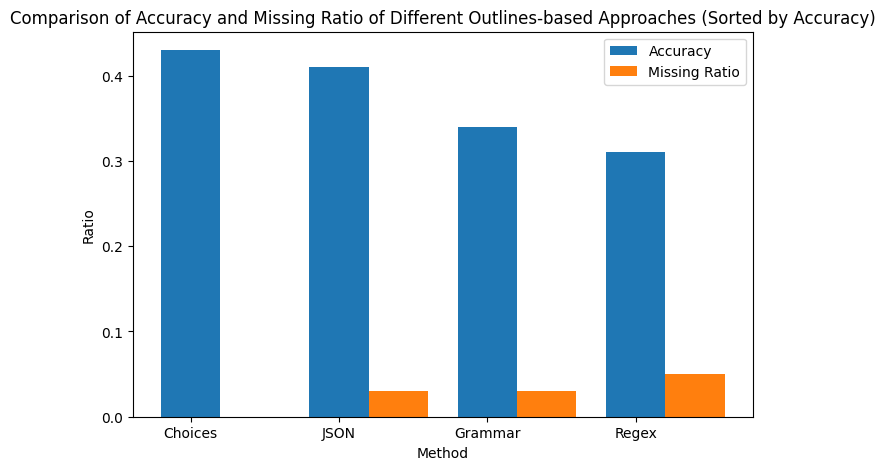

In [48]:
import matplotlib.pyplot as plt

methods = ["Choices", "JSON", "Regex", "Grammar"]
accuracies = [
    results_choices["accuracy"],
    results_json["accuracy"],
    results_regex["accuracy"],
    results_grammar["accuracy"],
]
missing_ratios = [
    results_choices["missing_ratio"],
    results_json["missing_ratio"],
    results_regex["missing_ratio"],
    results_grammar["missing_ratio"],
]

data = list(zip(methods, accuracies, missing_ratios))
sorted_data = sorted(data, key=lambda x: x[1], reverse=True)
sorted_methods, sorted_accuracies, sorted_missing_ratios = zip(*sorted_data)

print("Sorted Results:")
for method, accuracy, missing_ratio in sorted_data:
    print(f"Method: {method}, Accuracy: {accuracy:.2f}, Missing Ratio: {missing_ratio:.2f}")

x = range(len(sorted_methods))

plt.figure(figsize=(8, 5))
plt.bar(x, sorted_accuracies, width=0.4, label="Accuracy", align="center")
plt.bar([p + 0.4 for p in x], sorted_missing_ratios, width=0.4, label="Missing Ratio", align="center")

plt.xticks(x, sorted_methods)
plt.xlabel("Method")
plt.ylabel("Ratio")
plt.title("Comparison of Accuracy and Missing Ratio of Different Outlines-based Approaches (Sorted by Accuracy)")
plt.legend()
plt.show()

<div style="border: 2px solid green; padding: 10px; border-radius: 5px; background-color: darkgreen; width: 1000px;">
<b>Answer</b>
</div>


Among the four constrained decoding methods, the “Choices” approach achieved the highest accuracy (0.43) with no missing answers. The “JSON” method followed closely with slightly lower accuracy (0.41) but introduced some missing answers (0.03). The “Grammar” method performed moderately (0.34 accuracy, 0.03 missing ratio), and the “Regex” approach had the lowest accuracy (0.31) and the highest missing ratio (0.05). Overall, “Choices” provided the best balance of high accuracy and zero missing responses.

“Choices” likely performs best because it explicitly restricts the model’s output to predefined options, minimizing confusion and ensuring valid answers without empty results. The “JSON” method, while structured, introduces formatting constraints that can sometimes cause the model to skip producing a valid category. The “Grammar” and “Regex” approaches add complexity through syntactic or pattern-based rules, which may slightly prevent the model from directly following the intended categories. Overall, the simplest direct option selection (“Choices”) appears most effective at guiding our model to provide correct and complete answers.